In [1]:
from pandana.loaders import osm
import geopandas as gpd
import pydeck as pdk
import ee
import pandas as pd
import contextily as ctx
import plotly.express as px
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tobler.util import h3fy
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import multiprocessing
from tobler.area_weighted import area_interpolate
import plotly.io as pio
import transbigdata as tbd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import requests
import dask
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import LineString, MultiLineString, Point
import plotly.express as px
import io
import zipfile
import warnings
import numpy as np
import matplotlib.cm as cm
from tobler.area_weighted import area_interpolate
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandana
import contextily as cx
import matplotlib.patches as mpatches
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# # New York Sate (FIFP=36) boundary 
outlines = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_500k.zip')
outlines = outlines[outlines['GEOID'] == '36']  # New York State
outlines.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [3]:
# New York Sate (FIFP=36) county shapfile data
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
nyc_county_data = gpd.read_file(url)
nyc_county_data

boro_code      boro_name    shape_area     shape_leng  \
0        5.0  Staten Island  1.623621e+09  325917.353950   
1        1.0      Manhattan  6.365205e+08  357713.308162   
2        2.0          Bronx  1.187175e+09  463180.579449   
3        3.0       Brooklyn  1.934138e+09  728146.574928   
4        4.0         Queens  3.041419e+09  888199.731385   

                                            geometry  
0  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
1  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
2  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
3  MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...  
4  MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...

In [4]:
url = "https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_36_tract.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall()
gdf = gpd.read_file('tl_2020_36_tract.shp')

# Filter the data to include only NYC counties
nyc_counties = ["005", "047", "061", "081", "085"]
nyc_tract_data = gdf[gdf["COUNTYFP"].isin(nyc_counties)]

# Filter out water features (coastline)
nyc_tract_data = nyc_tract_data[nyc_tract_data['ALAND'] > 0]

# Desired variables
nyc_tract_data = nyc_tract_data[["GEOID", "geometry"]]

nyc_tract_data.head()

GEOID                                           geometry
0  36047000700  POLYGON ((-74.00154 40.69279, -74.00132 40.693...
1  36047000900  POLYGON ((-73.99405 40.69090, -73.99374 40.691...
2  36047001100  POLYGON ((-73.99073 40.69305, -73.99045 40.693...
3  36047001300  POLYGON ((-73.99141 40.69863, -73.99131 40.699...
4  36047002000  POLYGON ((-74.01867 40.64741, -74.01809 40.647...

In [5]:
ox.config(log_console=True, use_cache=True)

# Define the location you are interested in
place_name = "New York City, New York, USA"

# Fetch the street network for New York City
# network_type='drive' restricts this to drivable public streets
nyc_graph = ox.graph_from_place(place_name, network_type='drive')

# Convert the street network to two GeoDataFrames: nodes and edges
gdf_nodes, gdf_edges = ox.graph_to_gdfs(nyc_graph)

In [6]:
ev_station = pd.read_csv('alt_fuel_stations (Apr 5 2024).csv')
ny_ev_station = ev_station[ev_station['State'] == 'NY']
ny_ev_station  = ny_ev_station[['ID', 'Latitude', 'Longitude', 'Open Date', "Access Days Time", 'EV Connector Types', 'Facility Type', 'EV Pricing', "EV Workplace Charging"]]

# Perform a spatial join to find the stations within New York City
geometry = gpd.points_from_xy(ny_ev_station['Longitude'], ny_ev_station['Latitude'])
gdf = gpd.GeoDataFrame(ny_ev_station, geometry=geometry)
gdf.crs = nyc_county_data.crs
nyc_ev_station = gpd.sjoin(gdf, nyc_county_data, op='within') # spatial join
nyc_ev_station = nyc_ev_station.drop(columns=['geometry', 'index_right', 'boro_code', 'shape_leng'])
nyc_ev_station.head()

ID   Latitude  Longitude   Open Date  \
571   44323  40.758245 -73.776954  2011-11-30   
573   44329  40.589167 -73.960707  2011-11-30   
1289  49938  40.681060 -73.845540  2012-10-25   
2000  64140  40.587162 -74.194747  2014-11-01   
2093  65288  40.621698 -74.025670  2015-06-01   

                                       Access Days Time EV Connector Types  \
571                           Dealership business hours              J1772   
573   Dealership business hours; Nissan vehicle use ...              J1772   
1289                          Dealership business hours              J1772   
2000   Dealership business hours; for customer use only              J1772   
2093                                                NaN              J1772   

     Facility Type EV Pricing  EV Workplace Charging      boro_name  \
571     CAR_DEALER       Free                  False         Queens   
573     CAR_DEALER       Free                  False       Brooklyn   
1289    CAR_DEALER       Free                  False         Queens   
2000    CAR_DEALER       Free                  False  Staten Island   
2093           NaN        NaN                  False       Brooklyn   

        shape_area  
571   3.041419e+09  
573   1.934138e+09  
1289  3.041419e+09  
2000  1.623621e+09  
2093  1.934138e+09

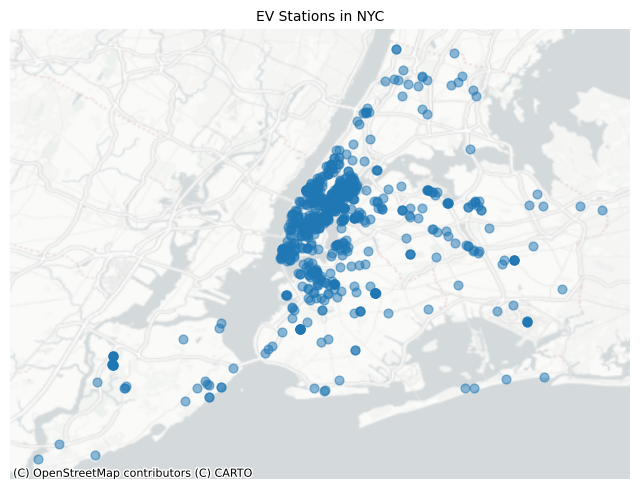

In [7]:
nyc_ev_station = gpd.GeoDataFrame(nyc_ev_station, geometry=gpd.points_from_xy(nyc_ev_station['Longitude'], nyc_ev_station['Latitude']), crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(8,8))
nyc_ev_station.plot(markersize=40, ax=ax, alpha=0.5)
ax.axis('off')
ax.set_title("EV Stations in NYC", fontsize=10)
cx.add_basemap(
    ax,
    crs=nyc_ev_station.crs.to_string(),
    source=cx.providers.CartoDB.PositronNoLabels,
    zoom=10
)
plt.show()

#fig, ax = plt.subplots(figsize=(8, 8))
#nyc_ev_station.plot(markersize=50, ax=ax, alpha=0.5)
#ax.axis('off')
#ax.set_title("NYC EV Charging Stations")
#plt.show()

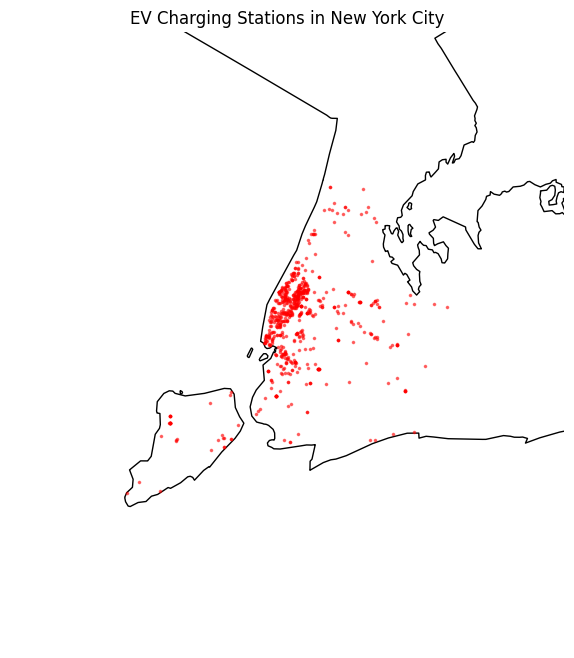

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
outlines.plot(ax=ax, facecolor='none', edgecolor='black')
nyc_ev_station.plot(alpha=0.5, markersize=10, ax=ax, marker='.', color='red')
ax.set_title("EV Charging Stations in New York City")

# Calculate buffer based on the 'nyc_ev_station' bounds to adjust the plot limits
buff = 0.2
ax.set_xlim(nyc_ev_station['geometry'].x.min() - buff, nyc_ev_station['geometry'].x.max() + buff)
ax.set_ylim(nyc_ev_station['geometry'].y.min() - buff, nyc_ev_station['geometry'].y.max() + buff)
ax.axis('off')
plt.show()

In [9]:
nyc_ev_station.index.name = 'id'
nyc_ev_station.reset_index(inplace=True)
nyc_ev_station.head()

id     ID   Latitude  Longitude   Open Date  \
0   571  44323  40.758245 -73.776954  2011-11-30   
1   573  44329  40.589167 -73.960707  2011-11-30   
2  1289  49938  40.681060 -73.845540  2012-10-25   
3  2000  64140  40.587162 -74.194747  2014-11-01   
4  2093  65288  40.621698 -74.025670  2015-06-01   

                                    Access Days Time EV Connector Types  \
0                          Dealership business hours              J1772   
1  Dealership business hours; Nissan vehicle use ...              J1772   
2                          Dealership business hours              J1772   
3   Dealership business hours; for customer use only              J1772   
4                                                NaN              J1772   

  Facility Type EV Pricing  EV Workplace Charging      boro_name  \
0    CAR_DEALER       Free                  False         Queens   
1    CAR_DEALER       Free                  False       Brooklyn   
2    CAR_DEALER       Free                  False         Queens   
3    CAR_DEALER       Free                  False  Staten Island   
4           NaN        NaN                  False       Brooklyn   

     shape_area                    geometry  
0  3.041419e+09  POINT (-73.77695 40.75825)  
1  1.934138e+09  POINT (-73.96071 40.58917)  
2  3.041419e+09  POINT (-73.84554 40.68106)  
3  1.623621e+09  POINT (-74.19475 40.58716)  
4  1.934138e+09  POINT (-74.02567 40.62170)

In [10]:
tracts_stations = gpd.sjoin(nyc_ev_station, nyc_tract_data.to_crs(nyc_ev_station.crs), how='inner', predicate='within')
tract_counts = tracts_stations.groupby('GEOID')['id'].count().reset_index()
tracts = pd.merge(nyc_tract_data, tract_counts, on='GEOID', how='left')
tracts['count'] = tracts['id'].fillna(0)
tracts = tracts.clip(outlines.to_crs(tracts.crs))  # clip tract geoms to coastline
tracts.head()

GEOID                                           geometry   id  \
320   36085024402  POLYGON ((-74.25443 40.50226, -74.25393 40.502...  NaN   
628   36085024401  POLYGON ((-74.25569 40.50773, -74.25525 40.507...  NaN   
1018  36085019800  POLYGON ((-74.22652 40.51906, -74.22631 40.518...  1.0   
617   36085024800  POLYGON ((-74.23927 40.52518, -74.23927 40.525...  1.0   
528   36085017600  POLYGON ((-74.19024 40.53274, -74.18946 40.533...  NaN   

      count  
320     0.0  
628     0.0  
1018    1.0  
617     1.0  
528     0.0

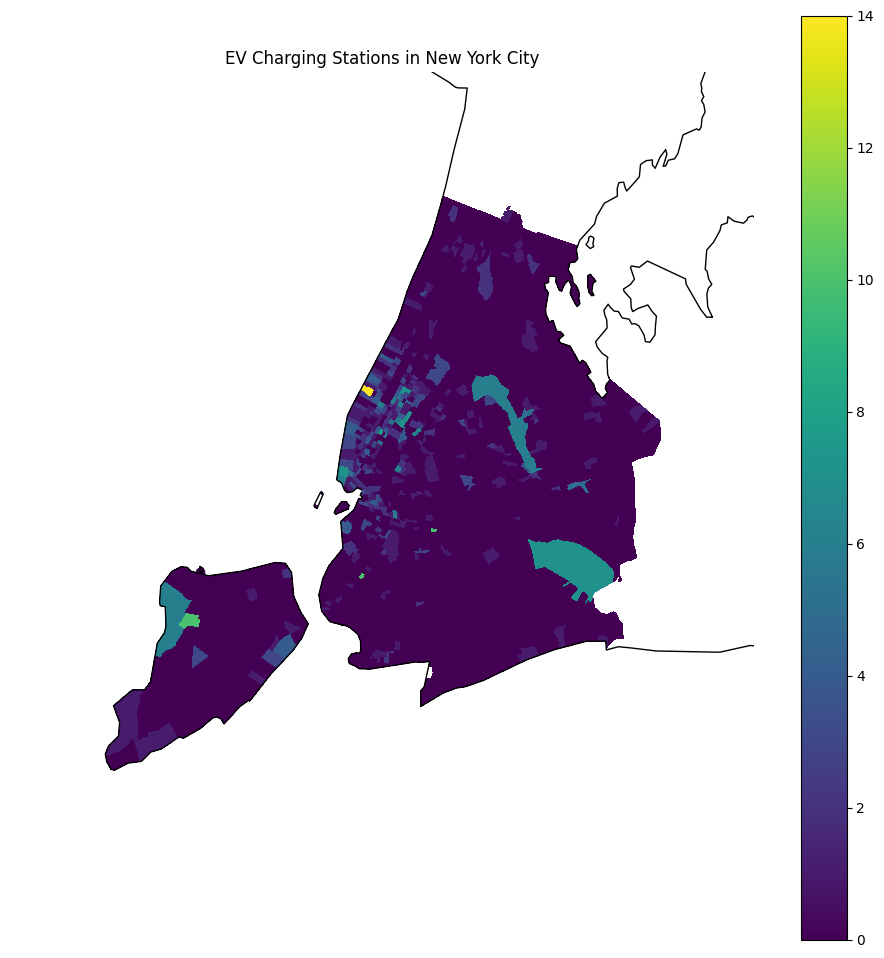

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
tracts.plot(
    column='count',
    ax=ax,
    legend=True,
    antialiased=False
    
)
outlines.plot(ax=ax, facecolor='none')
ax.set_title("EV Charging Stations in New York City")

buff = .1
ax.set_xlim(nyc_ev_station['geometry'].x.min() - buff, nyc_ev_station['geometry'].x.max() + buff)
ax.set_ylim(nyc_ev_station['geometry'].y.min() - buff, nyc_ev_station['geometry'].y.max() + buff)
ax.axis('off')
plt.show()

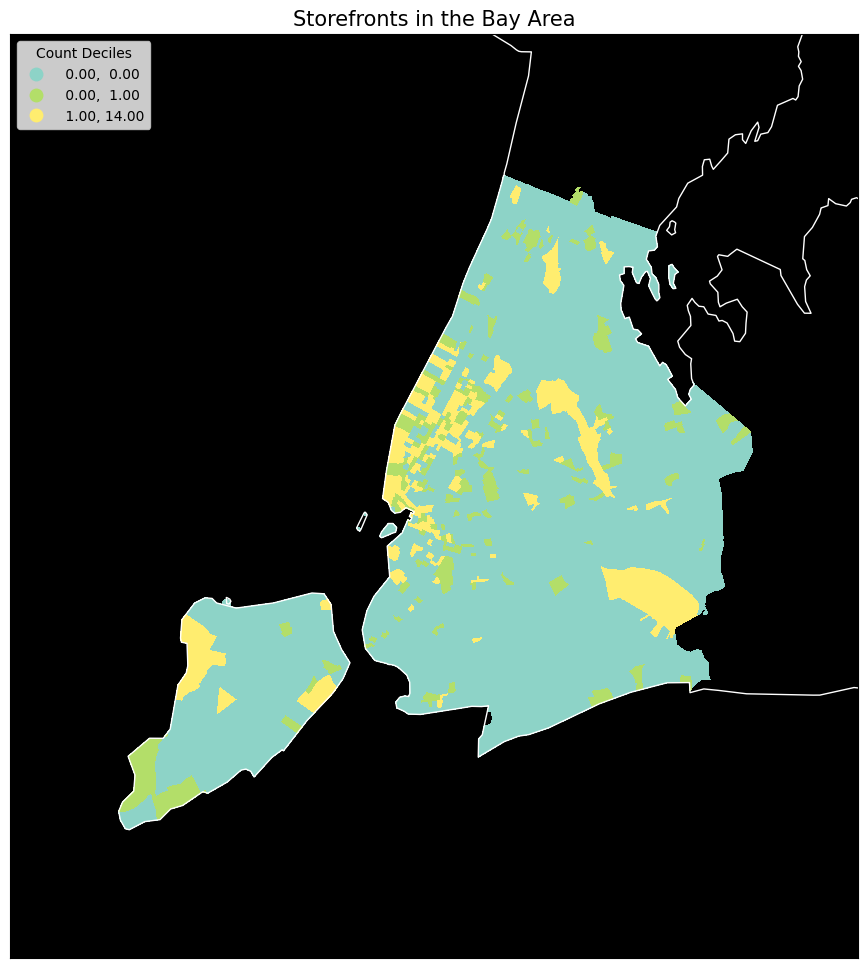

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))

tracts.plot(
    column='count',
    edgecolor='none',
    lw=0.01,
    ax=ax,
    scheme='quantiles',  # Choropleth classification scheme
    k=10,  # Number of bins
    legend=True,  # Automatically generate legend based on the quantiles
    legend_kwds={
        'title': 'Count Deciles',
        'loc': 'upper left',
    },
    cmap='Set3',  # plasma viridis magma Pastel1 tab20b
    antialiased=False
)

# Overlay outlines for context
outlines.plot(ax=ax, facecolor='none', edgecolor='white')

# Set additional aesthetics
ax.set_title("EV Charging Stations in New York City", fontsize=15)
ax.set_facecolor('k')
ax.set_xticks([])
ax.set_yticks([])

# Adjust the view to the extent of the data with a buffer
buff = 0.1
ax.set_xlim(nyc_ev_station['geometry'].x.min() - buff, nyc_ev_station['geometry'].x.max() + buff)
ax.set_ylim(nyc_ev_station['geometry'].y.min() - buff, nyc_ev_station['geometry'].y.max() + buff)
plt.show()

In [13]:
m = folium.Map(location=[40.7128, -74.0060], zoom_start=10, tiles='Cartodb Positron')  # CartoDB dark_matter

# Adding the choropleth layer for tracts based on the 'count' column
# Adjust the fill_color to something that stands out on a dark background
folium.Choropleth(
    geo_data=tracts.to_json(),  # Converts GeoDataFrame to GeoJSON string
    data=tracts,
    columns=['GEOID', 'count'],  # Use 'GEOID' for matching, 'count' for coloring
    key_on='feature.properties.GEOID',
    fill_color='RdYlBu',  # YlOrRd Plasma RdYlBu
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='EV Charging Station Count'
).add_to(m)

# Overlay the New York City boundaries on the map
folium.GeoJson(
    outlines.to_json(),
    name='NYC Boundary',
    style_function=lambda x: {'color': 'white', 'weight': 2, 'fillOpacity': 0}
).add_to(m)

folium.LayerControl().add_to(m)
m

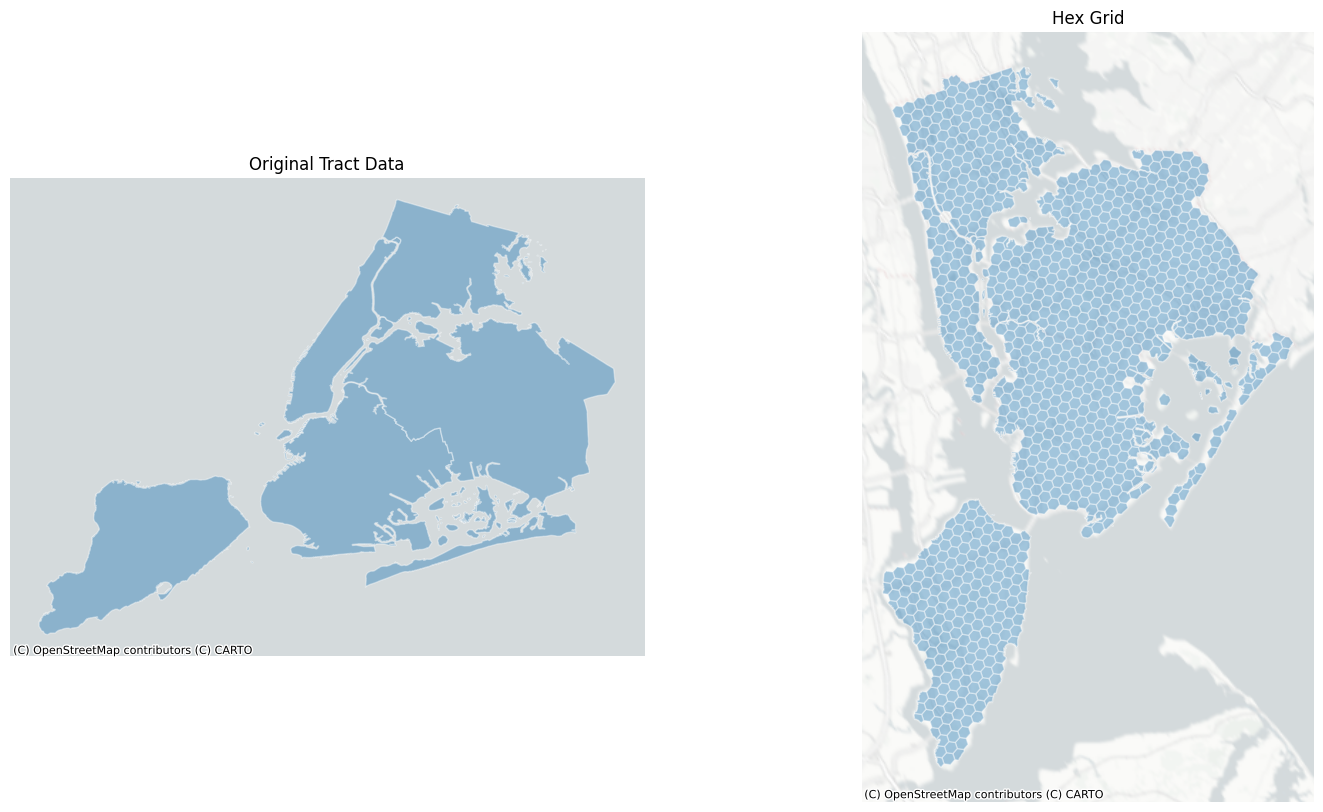

In [14]:
hexes = h3fy(nyc_county_data.to_crs('epsg:4326'), resolution=8, clip=True).to_crs("epsg:26910")

fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

nyc_county_data.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white')

axs[0].set_title('Original Tract Data')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.CartoDB.PositronNoLabels)
    axs[i].axis('off')

In [15]:
'''"CYPLAN255 - ZeyuWu.ipynb"
hexes = hexes.reset_index()
hexes_stations = gpd.sjoin(nyc_ev_station, hexes.to_crs(nyc_ev_station.crs), how='inner', predicate='within')
hexes_counts = hexes_stations.groupby('hex_id')['id'].count().reset_index()
hexes = pd.merge(hexes, hexes_counts, on='hex_id', how='left')
hexes['count'] = hexes['id'].fillna(0)
# hexes = hexes.clip(outlines.to_crs(hexes.crs))  # clip tract geoms to coastline
'''

'"CYPLAN255 - ZeyuWu.ipynb"\nhexes = hexes.reset_index()\nhexes_stations = gpd.sjoin(nyc_ev_station, hexes.to_crs(nyc_ev_station.crs), how=\'inner\', predicate=\'within\')\nhexes_counts = hexes_stations.groupby(\'hex_id\')[\'id\'].count().reset_index()\nhexes = pd.merge(hexes, hexes_counts, on=\'hex_id\', how=\'left\')\nhexes[\'count\'] = hexes[\'id\'].fillna(0)\n# hexes = hexes.clip(outlines.to_crs(hexes.crs))  # clip tract geoms to coastline\n'

In [16]:
hexes

geometry
hex_id                                                            
882a106e0dfffff  POLYGON ((4651210.325 5803800.724, 4651011.549...
882a106e63fffff  POLYGON ((4651011.549 5804403.291, 4651210.325...
882a106e67fffff  POLYGON ((4649932.570 5803993.461, 4650131.338...
882a106e47fffff  POLYGON ((4652331.853 5805922.146, 4652530.701...
882a106e6bfffff  POLYGON ((4651252.813 5805512.142, 4651451.652...
...                                                            ...
882a100165fffff  POLYGON ((4648999.835 5868947.956, 4649202.595...
882a100a59fffff  POLYGON ((4647920.916 5868532.220, 4648123.667...
882a10016dfffff  POLYGON ((4649235.090 5870062.623, 4649437.915...
882a1018b3fffff  POLYGON ((4648156.161 5869646.778, 4648358.977...
882a1018b7fffff  POLYGON ((4647077.278 5869230.998, 4647280.085...

[1055 rows x 1 columns]

In [17]:
hexes = hexes.reset_index()

hexes = hexes.to_crs(nyc_ev_station.crs)

hexes_stations = gpd.sjoin(nyc_ev_station, hexes, how='inner', predicate='within')
hexes_counts = hexes_stations.groupby('hex_id').size().reset_index(name='count')
hexes = pd.merge(hexes, hexes_counts, on='hex_id', how='left')
hexes['count'] = hexes['count'].fillna(0)

# Ensure hexes is in a CRS that measures in meters; CRS will depend on the location
hexes = hexes.to_crs('EPSG:32618')

# Calculate the area in square kilometers (1 square meter = 0.000001 square kilometers)
hexes['area_km2'] = hexes['geometry'].area / 1e6

# Calculate the density of stations per square kilometer
hexes['density'] = hexes['count'] / hexes['area_km2']

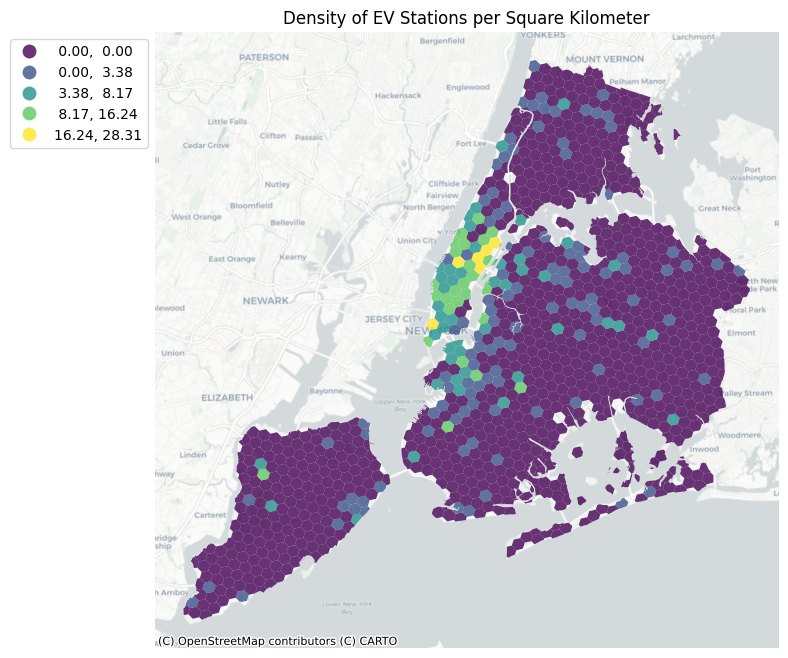

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

hexes.plot(
    'density',  # Use the 'density' column calculated previously
    scheme='fisherjenks',  # Classification scheme
    alpha=0.8,
    ax=ax,
    edgecolor='none',
    legend=True,  # Optionally add a legend
    cmap='viridis'  # Color map
)

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    crs=hexes.crs.to_string())
ax.axis('off')

# Move the legend to the upper left
legend = ax.get_legend()
legend.set_bbox_to_anchor((0, 1))

ax.set_title('Density of EV Stations per Square Kilometer')
plt.show()

In [20]:
hexes.rename(columns = {"count": "EV_Station_Count", "density":"EV_Station_Density"},  inplace=True)

In [21]:
hexes.head()

hex_id                                           geometry  \
0  882a106e0dfffff  POLYGON ((564391.406 4483712.571, 564550.811 4...   
1  882a106e63fffff  POLYGON ((564550.811 4484208.004, 564391.406 4...   
2  882a106e67fffff  POLYGON ((563637.579 4484457.739, 563478.197 4...   
3  882a106e47fffff  POLYGON ((566159.771 4484576.585, 566000.320 4...   
4  882a106e6bfffff  POLYGON ((565246.554 4484826.329, 565087.125 4...   

   EV_Station_Count  area_km2  EV_Station_Density  
0               0.0  0.548716                 0.0  
1               0.0  0.738377                 0.0  
2               0.0  0.324066                 0.0  
3               0.0  0.738411                 0.0  
4               0.0  0.738450                 0.0

In [22]:
hexes.to_csv('NYC_EV_STATION_HEX.csv')